In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def correspondence_selection(image1, image2, cor_num):
    # This function takes 2 images and the desired number of corresponding pairs as input.
    # It returns the coordinates of selected correspondence points for image1 and image2 with 1-to-1 order.
    
    if image1.shape[0] == image2.shape[0]:
        im = np.concatenate( (image1, 255*np.ones((image1.shape[0], 50, image1.shape[2]))), axis=1 )
        im = np.concatenate( (im, image2), axis=1).astype(int)
    elif image2.shape[0] > image1.shape[0]:
        delta = image2.shape[0] - image1.shape[0]
        image1 = np.concatenate((image1, np.zeros((delta, image1.shape[1], image1.shape[2]))), axis=0)
        im = np.concatenate( (image1, 255*np.ones((image1.shape[0], 50, image1.shape[2]))), axis=1 )
        im = np.concatenate( (im, image2), axis=1).astype(int)
    else:
        delta = image1.shape[0] - image2.shape[0]
        image2 = np.concatenate((image2, np.zeros((delta, image2.shape[1], image2.shape[2]))), axis=0)
        im = np.concatenate( (image1, 255*np.ones((image1.shape[0], 50, image1.shape[2]))), axis=1 )
        im = np.concatenate( (im, image2), axis=1).astype(int)
    
    
    %matplotlib tk
    plt.figure(figsize = (100,100))
    plt.imshow(im) # Open image in a distinct window
    points = plt.ginput(cor_num*2,timeout=300) # Choose initial points as desired
    plt.close()
    %matplotlib inline
    
    points = np.array(points)
    
    im1_points = points[0::2,:]
    
    im2_points = points[1::2,:]
    im2_points[:,0] = im2_points[:,0] - 50 - image1.shape[1]
    
    return im1_points, im2_points

In [3]:
def NormalizeCorrespondingPoints(im1_points, im2_points):
    
    shift1 = np.mean(im1_points, axis=0)
    shift2 = np.mean(im2_points, axis=0)
    
    scale1 = np.std(im1_points, axis=0) / np.sqrt(2)
    scale2 = np.std(im2_points, axis=0) / np.sqrt(2)
    
    T1 = np.array([[1/scale1[0], 0, -shift1[0]/scale1[0]], [0, 1/scale1[1], -shift1[1]/scale1[1]], [0, 0, 1]])
    T2 = np.array([[1/scale2[0], 0, -shift2[0]/scale2[0]], [0, 1/scale2[1], -shift2[1]/scale2[1]], [0, 0, 1]])
    
    im1_points = im1_points.T
    im1_points = np.concatenate((im1_points, np.ones((1,im1_points.shape[1]))), axis=0)
    im1_points = np.dot(T1, im1_points)
    im1_points = im1_points[0:2,:].T
    
    
    im2_points = im2_points.T
    im2_points = np.concatenate((im2_points, np.ones((1,im2_points.shape[1]))), axis=0)
    im2_points = np.dot(T2, im2_points)
    im2_points = im2_points[0:2,:].T
    
    return im1_points, im2_points, T1, T2

In [4]:
def computeH(im1_points, im2_points):
    n = im1_points.shape[0]
    
    column1 = np.zeros((n*2, 3))
    column1[0::2, :] = np.concatenate((im1_points, np.ones((n,1))), axis=1)
    
    column2 = np.zeros((n*2, 3))
    column2[1::2, :] = np.concatenate((im1_points, np.ones((n,1))), axis=1)
    
    column3 = - column1 - column2
    column3 = column3 * im2_points.flatten().reshape((n*2, 1))
    
    A = np.concatenate((column1, column2), axis=1)
    A = np.concatenate((A, column3), axis=1)
    
    _, _, U = np.linalg.svd(A, full_matrices=False)
    h = U[-1,:]
    
    H = h.reshape((3,3))
    H = H / H[-1,-1]
    
    return H

In [5]:
def interpolate(image, coor):
    grid_colors = np.zeros( (3,coor.shape[1]))
    
    for i in range(coor.shape[1]):
        x, y = int(coor[0,i]), int(coor[1,i])
        if (x>=0) and (x<image.shape[1]) and (y>=0) and (y<image.shape[0]):
            
            grid_colors[0,i] = np.mean(image[y:y+2, x:x+2, 0])
            grid_colors[1,i] = np.mean(image[y:y+2, x:x+2, 1])
            grid_colors[2,i] = np.mean(image[y:y+2, x:x+2, 2])
        else:
            grid_colors[0,i] = 0
            grid_colors[1,i] = 0
            grid_colors[2,i] = 0
    
    grid_colors = np.clip(grid_colors, 0, 255).astype('int')
    return grid_colors

In [6]:
def warp(image, H, T1=np.identity(3), T2=np.identity(3)):
    y, x = image.shape[0], image.shape[1]
    
    x_vec = np.arange(0, x, 1).reshape((1,x))
    x_vec = np.tile(x_vec, y)
    y_vec = np.arange(0, y, 1).reshape((1,y))
    y_vec = np.repeat(y_vec, x, axis=1)
    
    coor_stack = np.concatenate((x_vec, y_vec), axis=0)
    coor_stack = np.concatenate((coor_stack, np.ones((1,x*y))), axis=0)
    
    # Transform the original image coordinates to the target frame to find image boundaries: 
    coor_transformed = np.dot(T1, coor_stack)
    coor_transformed = np.dot(H, coor_transformed)
    coor_transformed = np.dot(np.linalg.inv(T2), coor_transformed)  
    coor_transformed = coor_transformed / coor_transformed[-1,:] 
    coor_transformed = coor_transformed[0:2, :]
    
    # Find the image boundaries of warped image on the target frame:
    y_min, y_max = int(np.min(coor_transformed[1,:])), int(np.max(coor_transformed[1,:]))
    x_min, x_max = int(np.min(coor_transformed[0,:])), int(np.max(coor_transformed[0,:]))
    
    # Create grid coordinates by using boundaries:
    x_vec = np.arange(x_min, x_max, 1).reshape((1,x_max-x_min))
    x_vec = np.tile(x_vec, y_max-y_min)
    y_vec = np.arange(y_min, y_max, 1).reshape((1,y_max-y_min))
    y_vec = np.repeat(y_vec, x_max-x_min, axis=1)
    
    coor_grid = np.concatenate((x_vec, y_vec), axis=0)
    coor_grid = np.concatenate((coor_grid, np.ones((1,(x_max-x_min)*(y_max-y_min)))), axis=0)
        
    # Inverse transform each grid coordinates back:
    coor_back = np.dot(T2, coor_grid)
    coor_back = np.dot(np.linalg.inv(H), coor_back)
    coor_back = np.dot(np.linalg.inv(T1), coor_back)
    coor_back = coor_back[0:2,:] / coor_back[-1,:]
        
    # Interpolate on the original coordinate frame to find pixel values of new frame:
    grid_colors = interpolate(image, coor_back)
    
    # Resize the color matrix:
    wrapped_image = np.zeros((y_max-y_min , x_max-x_min , 3))
    wrapped_image[:,:,0] = grid_colors[0,:].reshape(y_max-y_min , x_max-x_min)
    wrapped_image[:,:,1] = grid_colors[1,:].reshape(y_max-y_min , x_max-x_min)
    wrapped_image[:,:,2] = grid_colors[2,:].reshape(y_max-y_min , x_max-x_min)
    
    return wrapped_image.astype('int'), (y_min, y_max, x_min, x_max)

In [7]:
def blending(image1, image2, boundaries):
    (y1_min, y1_max, x1_min, x1_max) = boundaries
    
    y2_min, x2_min = 0, 0
    y2_max, x2_max = image2.shape[0], image2.shape[1]
    
    del_y_top = y2_min - y1_min
    del_y_bottom = y1_max - y2_max
    del_x_left = x2_min - x1_min
    del_x_right = x1_max - x2_max
    
    if del_y_top > 0:
        image2 = np.concatenate(( np.zeros((del_y_top,image2.shape[1],image2.shape[2])) , image2 ), axis=0 )
    if del_y_bottom > 0:
        image2 = np.concatenate( ( image2 , np.zeros((del_y_bottom,image2.shape[1],image2.shape[2])) ), axis=0 )
    if del_x_left > 0:
        image2 = np.concatenate(( np.zeros((image2.shape[0],del_x_left,image2.shape[2])) , image2 ), axis=1 )
    if del_x_right > 0:
        image2 = np.concatenate( ( image2 , np.zeros((image2.shape[0],del_x_right,image2.shape[2])) ), axis=1 )
        
    if del_y_top < 0:
        image1 = np.concatenate(( np.zeros((np.abs(del_y_top),image1.shape[1],image1.shape[2])) , image1 ), axis=0 )
    if del_y_bottom < 0:
        image1 = np.concatenate( ( image1 , np.zeros((np.abs(del_y_bottom),image1.shape[1],image1.shape[2])) ), axis=0 )
    if del_x_left < 0:
        image1 = np.concatenate(( np.zeros((image1.shape[0],np.abs(del_x_left),image1.shape[2])) , image1 ), axis=1 )
    if del_x_right < 0:
        image1 = np.concatenate( ( image1 , np.zeros((image1.shape[0],np.abs(del_x_right),image1.shape[2])) ), axis=1 )
        
    blended_image = np.maximum(image1, image2)
        
    return blended_image.astype('int')

In [9]:
# Choose number of corresponding point pairs:
n = 10

# Choose if wrong selection will be applied. m is number of wrong pairs:
wrong=False
m = 2

# Choose if noise will be added. var is the variance of zero mean Gaussian noise:
noise=False
var = 2

# Choose if normalization will be applied:
normalization=True

# STITCH paris_a on paris_b:

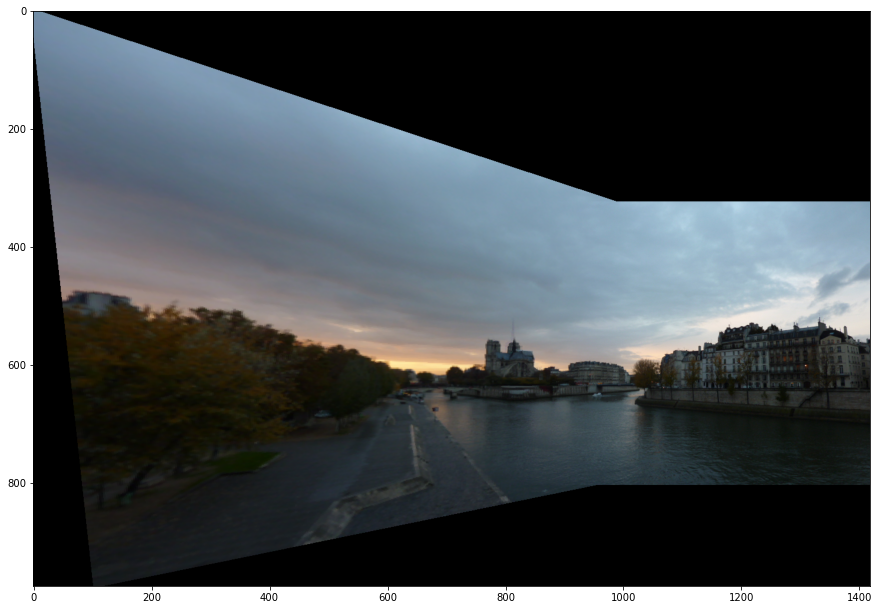

In [10]:
directory = 'images/paris/'

# Stitch paris_a on paris_b:
image1 = plt.imread(directory+'paris_a.jpg')
image2 = plt.imread(directory+'paris_b.jpg')

# Select n pairs of corresponding points between 2 images and save them:
#im1_p, im2_p = correspondence_selection(image1, image2, n)
#paris_a_to_b = np.zeros((im1_p.shape[0], im1_p.shape[1], 2))
#paris_a_to_b[:,:,0] = im1_p
#paris_a_to_b[:,:,1] = im2_p
#np.save('CorrPoints/'+'paris_a_to_b'+'_'+str(n), paris_a_to_b)

# Load the image correspondence pairs:
paris_a_to_b = np.load('CorrPoints/'+'paris_a_to_b'+'_'+str(n)+'.npy')
im1_p = paris_a_to_b[:,:,0]
im2_p = paris_a_to_b[:,:,1]

# Add m pairs of wrong selections (if needed):
if wrong==True:
    x_rand = np.random.randint(low=0, high=image1.shape[1]-1, size=(m,1))
    y_rand = np.random.randint(low=0, high=image1.shape[0]-1, size=(m,1))
    rand = np.concatenate((x_rand, y_rand), axis=1)
    im1_p = np.concatenate((im1_p,rand), axis=0)
    
    x_rand = np.random.randint(low=0, high=image2.shape[1]-1, size=(m,1))
    y_rand = np.random.randint(low=0, high=image2.shape[0]-1, size=(m,1))
    rand = np.concatenate((x_rand, y_rand), axis=1)
    im2_p = np.concatenate((im2_p,rand), axis=0)
    
# Add noise on corresponding points (if needed):
if noise==True:
    im1_p = im1_p + np.random.normal(loc=0.0, scale=var, size=im1_p.shape)
    im2_p = im2_p + np.random.normal(loc=0.0, scale=var, size=im2_p.shape)

# Normalize the corresponding pairs before estimating the homeography:
if normalization==True:
    im1_p, im2_p, T1, T2 = NormalizeCorrespondingPoints(im1_p, im2_p)
else:
    im1_p, im2_p, T1, T2 = im1_p, im2_p, np.identity(3), np.identity(3)

# Estimate the homeography matrix between normalized pairs:
H = computeH(im1_p, im2_p)

# Image wrapping:
wrapped_image, boundaries = warp(image1, H, T1, T2)

# Blend the wrapped image with target image:
paris_ab = blending(wrapped_image, image2, boundaries)

plt.figure(figsize = (15,20))
plt.imshow(paris_ab)

del image1, image2, im1_p, im2_p, H, wrapped_image, boundaries

# STITCH paris_c on paris_b:

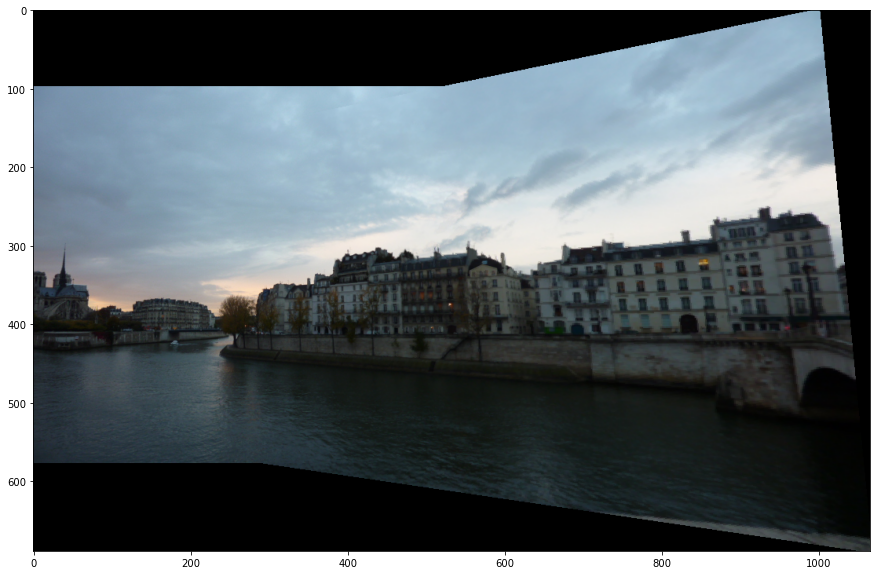

In [11]:
# Stitch paris_c on paris_b:
image1 = plt.imread(directory+'paris_c.jpg')
image2 = plt.imread(directory+'paris_b.jpg')

# Select n pairs of corresponding points between 2 images and save them:
#im1_p, im2_p = correspondence_selection(image1, image2, n)
#paris_c_to_b = np.zeros((im1_p.shape[0], im1_p.shape[1], 2))
#paris_c_to_b[:,:,0] = im1_p
#paris_c_to_b[:,:,1] = im2_p
#np.save('CorrPoints/'+'paris_c_to_b'+'_'+str(n), paris_c_to_b)

# Load the image correspondence pairs:
paris_c_to_b = np.load('CorrPoints/'+'paris_c_to_b'+'_'+str(n)+'.npy')
im1_p = paris_c_to_b[:,:,0]
im2_p = paris_c_to_b[:,:,1]

# Add m pairs of wrong selections (if needed):
if wrong==True:
    x_rand = np.random.randint(low=0, high=image1.shape[1]-1, size=(m,1))
    y_rand = np.random.randint(low=0, high=image1.shape[0]-1, size=(m,1))
    rand = np.concatenate((x_rand, y_rand), axis=1)
    im1_p = np.concatenate((im1_p,rand), axis=0)
    
    x_rand = np.random.randint(low=0, high=image2.shape[1]-1, size=(m,1))
    y_rand = np.random.randint(low=0, high=image2.shape[0]-1, size=(m,1))
    rand = np.concatenate((x_rand, y_rand), axis=1)
    im2_p = np.concatenate((im2_p,rand), axis=0)

# Add noise on corresponding points (if needed):
if noise==True:
    im1_p = im1_p + np.random.normal(loc=0.0, scale=var, size=im1_p.shape)
    im2_p = im2_p + np.random.normal(loc=0.0, scale=var, size=im2_p.shape)    
    
# Normalize the corresponding pairs before estimating the homeography:
if normalization==True:
    im1_p, im2_p, T1, T2 = NormalizeCorrespondingPoints(im1_p, im2_p)
else:
    im1_p, im2_p, T1, T2 = im1_p, im2_p, np.identity(3), np.identity(3)

# Estimate the homeography matrix between normalized pairs:
H = computeH(im1_p, im2_p)

# Image wrapping:
wrapped_image, boundaries = warp(image1, H, T1, T2)

# Blend the wrapped image with target image:
paris_cb = blending(wrapped_image, image2, boundaries)

plt.figure(figsize = (15,20))
plt.imshow(paris_cb)

del image1, image2, im1_p, im2_p, H, wrapped_image, boundaries

# STITCH paris_cb on paris_ab:

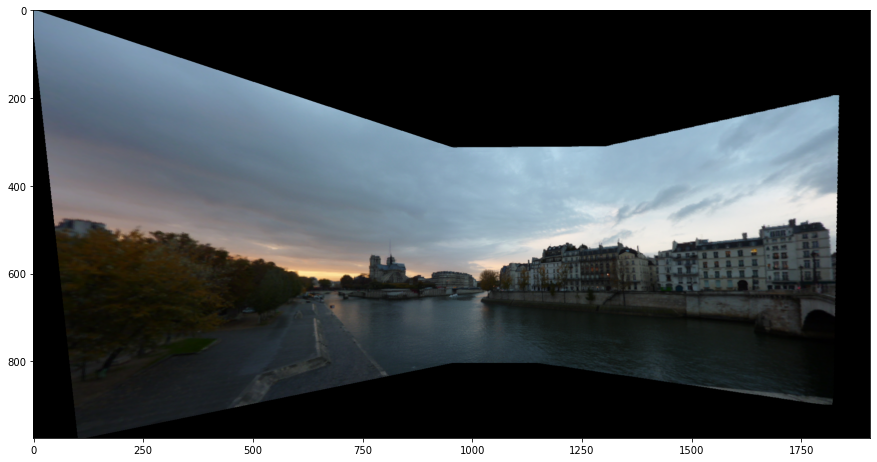

In [12]:
# Stitch paris_c on paris_ab:
image1 = paris_cb
image2 = paris_ab

# Select n pairs of corresponding points between 2 images and save them:
#im1_p, im2_p = correspondence_selection(image1, image2, n)
#paris_cb_to_ab = np.zeros((im1_p.shape[0], im1_p.shape[1], 2))
#paris_cb_to_ab[:,:,0] = im1_p
#paris_cb_to_ab[:,:,1] = im2_p
#np.save('CorrPoints/'+'paris_cb_to_ab'+'_'+str(n), paris_cb_to_ab)

# Load the image correspondence pairs:
paris_cb_to_ab = np.load('CorrPoints/'+'paris_cb_to_ab'+'_'+str(n)+'.npy')
im1_p = paris_cb_to_ab[:,:,0]
im2_p = paris_cb_to_ab[:,:,1]

# Normalize the corresponding pairs before estimating the homeography:
if normalization==True:
    im1_p, im2_p, T1, T2 = NormalizeCorrespondingPoints(im1_p, im2_p)
else:
    im1_p, im2_p, T1, T2 = im1_p, im2_p, np.identity(3), np.identity(3)

# Estimate the homeography matrix between normalized pairs:
H = computeH(im1_p, im2_p)

# Image wrapping:
wrapped_image, boundaries = warp(image1, H, T1, T2)

# Blend the wrapped image with target image:
blended_image = blending(wrapped_image, image2, boundaries)

plt.figure(figsize = (15,20))
plt.imshow(blended_image)

del image1, image2, im1_p, im2_p, H, wrapped_image, boundaries